In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-05-31 10:45:27.643350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf. __version__)

2.11.0


In [3]:
dev = qml.device('default.mixed', wires=3)

In [4]:
def real():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)

In [5]:
print(qml.draw(real)())

0: ──Rot(0.00,1.57,0.52)─┤  


In [6]:
def generator(w,**kwargs):
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=0)
    qml.BitFlip(p, wires=0)
    qml.BitFlip(p, wires=1)

In [7]:
print(qml.draw(generator)([ 0,0,0,0,0,0,0,0,0]))

0: ──RX(0.00)──RY(0.00)──RZ(0.00)─╭●──RX(0.00)───────RY(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)
1: ──RX(0.00)──RY(0.00)──RZ(0.00)─╰X──BitFlip(0.00)──────────────────────────────────────────

───BitFlip(0.00)─┤  
─────────────────┤  


In [8]:
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)
    qml.BitFlip(p, wires=0)
    qml.BitFlip(p, wires=2)

In [9]:
print(qml.draw(discriminator)([ 0,1,2,3,4,5,6,7,8]))

0: ──H─────────RX(0.00)──RY(2.00)──RZ(4.00)─╭●──BitFlip(0.00)────────────────────────────────────┤  
2: ──RX(1.00)──RY(3.00)──RZ(5.00)───────────╰X──RX(6.00)───────RY(7.00)──RZ(8.00)──BitFlip(0.00)─┤  


In [10]:
@qml.qnode(dev, interface='tf')
def real_disc_circuit(disc_weights):
    real()
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.qnode(dev,interface='tf')
def gen_disc_circuit(gen_weights,disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

In [11]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(disc_weights)
    #convert to probability
    prob_real_true = (true_disc_output+1)/2
    return prob_real_true

In [12]:
def prob_fake_true(gen_weights,disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights,disc_weights)
    #convert to probability
    prob_fake_true = (fake_disc_output+1)/2
    return prob_fake_true

In [13]:
def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights,disc_weights)-prob_real_true(disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = -prob_fake_true(gen_weights,disc_weights)
    return cost

In [18]:
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   #np.random.normal(scale=eps, size=(9,))
    
init_gen_weights = np.array([0]*9)
init_disc_weights = np.random.normal(size=(9,))
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

In [19]:
print(init_gen_weights)

[0 0 0 0 0 0 0 0 0]


In [ ]:
loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
p = 0.1
epochs = 3
for i in range(epochs):
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step_d.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step_g.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
    
loss_d = [ -x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss")
plt.plot(range(len(step_d)), loss_d, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Step 0: cost = -0.22749195292622004
Step 5: cost = -0.32473604476518775
Step 10: cost = -0.3521040326437952
Step 15: cost = -0.35831112870132903
Step 20: cost = -0.3596423561466814
Step 25: cost = -0.35992441945344744
Step 30: cost = -0.35998403423390085
Step 35: cost = -0.35999662763359885
Step 40: cost = -0.35999928768278755
Step 45: cost = -0.35999984954344577
Step 0: cost = -0.3716830356855156
Step 5: cost = -0.5662846391890999
Step 10: cost = -0.7244334384785384
Step 15: cost = -0.7922031781174643
Step 20: cost = -0.8126620553519734
Step 25: cost = -0.8181162304518409
Step 30: cost = -0.8195199444484037
Step 35: cost = -0.8198778938810897
Step 40: cost = -0.8199689561333391
Step 45: cost = -0.8199921084119375
Step 0: cost = 0.07143106055235326
Step 5: cost = -0.1797669276151721
Step 10: cost = -0.31541806181908083
Step 15: cost = -0.3540976346488479
Step 20: cost = -0.3627328090704318
Step 25: cost = -0.364544873877664


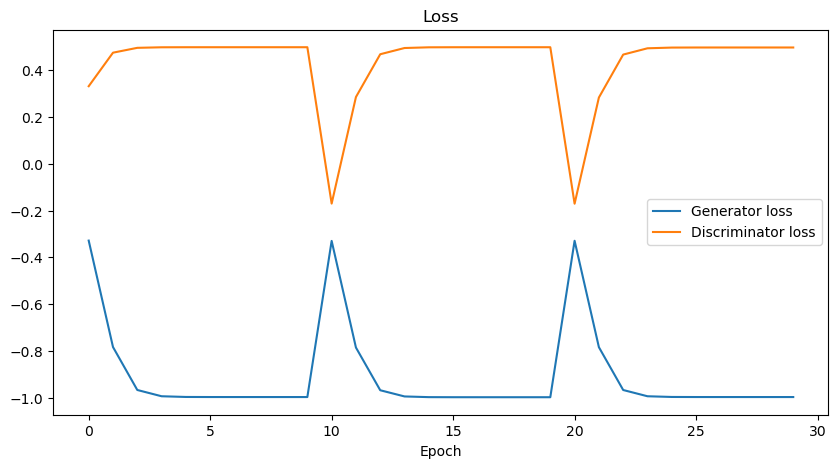

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss")
plt.plot(range(len(step_d)), loss_d, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()